In [1]:
"for the cdc news" #there are 47 trancripts/statements/media briefings from the CDC
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import string
import regex as re
import spacy
#step 1: get a list of file names to read into the dataset
repo_path = os.path.dirname(os.getcwd()) #get the correct file path 
cdc_paths = glob.glob(repo_path + "/data/01-raw/cdc_press_releases/*.txt") #the paths for the rachel maddow transcript files



## Update Stop Words
Add host names and other words to set of English stop words to exclude from analysis

In [2]:
from sklearn.feature_extraction import text

#text.ENGLISH_STOP_WORDS

In [3]:
# add host names, etc
add_stop_words = ['question', 'cdc', "fauci", "dr", "thanks", "thank", "people"] #add thanks to stop words

In [4]:
# add stop words to English set
full_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

## Define COVID terms
Define groups of terms referring to COVID, vaccines, masks

In [5]:
# covid terms
covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 'covid19', 'virus']

In [6]:
# vaccine terms
vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 'vaxxed']

In [7]:
# mask terms
mask_terms = ['mask', 'masking']

## Read in the Datasets


In [8]:
cdc_paths[0]

'/Users/tobijegede/Documents/GitHub/opinion-news-nlp/data/01-raw/cdc_press_releases/February_12_2021_cdc_transcript.txt'

In [9]:
text_transcripts = [] # container for transcript text
text_sentences = [] # container for sentence text
covid_counts_transcripts = [] # container for transcript covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in cdc_paths:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts.append(cov_trans_counter)


In [10]:
# display simple counts
print("Our CDC 'neutral' corpus consists of {:,} total transcripts.".format(len(text_transcripts)))

print("There are {:,} transcripts that mention COVID at least once.".format(len(text_transcripts) - covid_counts_transcripts.count(0)))

Our CDC 'neutral' corpus consists of 47 total transcripts.
There are 46 transcripts that mention COVID at least once.


## Word Frequency Analysis

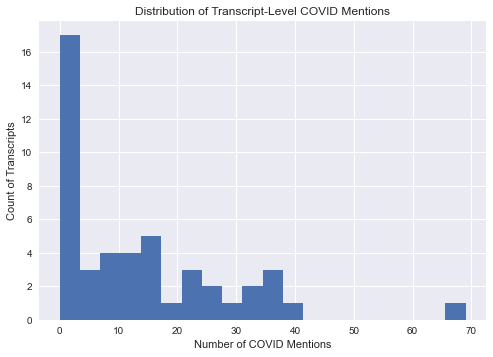

In [45]:
#print(covid_counts_transcripts)

fig = plt.figure() #added by Tobi to extract the graphics

# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

plt.hist(covid_counts_transcripts, bins = 20)
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Transcript-Level COVID Mentions')

plt.show()

fig.savefig(repo_path + '/images/cdc-distribution-covid-mentions.png')

In [12]:
#import packages
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

In [13]:
 # step 1: set up the vectorizer
min_df_threshold = int(np.floor(0.3 * len(text_transcripts)))
vectorizer = CountVectorizer(min_df = min_df_threshold,  #there are already much fewer transcripts + words in the cdc corpus, so I just made the rule that a word need to occur in at least a 1/3 of the documents to be counted
                                stop_words = full_stop_words)
                               # max_df = 0.8)

# step 2: apply the vectorizer to the corpus of documents and store in document matrix X
X = vectorizer.fit(text_transcripts)

# step 3: fit transform corpus of documents
X_transformed = vectorizer.fit_transform(text_transcripts)

# step 4: extract feature names and counts, create dictionary
array_of_words = vectorizer.get_feature_names_out()
array_of_counts = X_transformed.toarray().sum(axis = 0)
word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))



In [14]:
print("There are {:,} unique words in the vocabulary.".format(X_transformed.shape[1]))

There are 279 unique words in the vocabulary.


In [15]:
# set number of top words to see
num_top_words = 10

top_words = dict(sorted(word_frequency_dictionary.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_words)

{'health': 407, 'covid': 390, 'know': 379, 'think': 277, 'time': 270, 'risk': 246, 'public': 232, 'cases': 226, 'data': 224, 'today': 221}


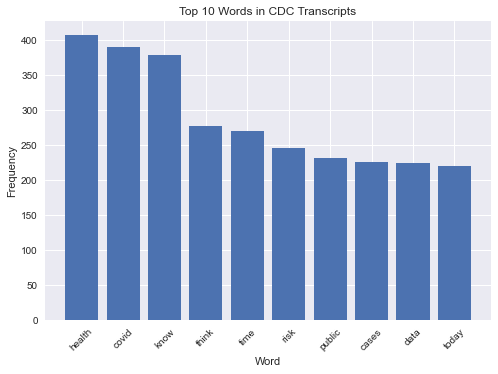

In [46]:
# plot top words
plt.style.use('seaborn')

fig = plt.figure() #added by Tobi to extract the graphics

x = top_words.keys()
y = top_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top {} Words in CDC Transcripts'.format(num_top_words))


plt.show()

fig.savefig(repo_path +'/images/cdc-top-words.png')


## Co-Occurence Analysis

In [17]:
#import required packages
from collections import Counter
import spacy

In [18]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [19]:
%%time
# nlp parse transcripts
nlp_list_trans = [nlp(text) for text in text_transcripts]

CPU times: user 11.4 s, sys: 1.41 s, total: 12.8 s
Wall time: 20.1 s


In [20]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [21]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_trans)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_trans) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [22]:
# print top 100 words (by PMI) that co-occur with COVID terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in covid_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
’s                        41              41              0.03103        
follow                    36              36              0.03103        
provide                   35              35              0.03103        
important                 34              34              0.03103        
health                    33              33              0.03103        
disease                   32              32              0.03103        
recommendation            31              31              0.03103        
like                      30              30              0.03103        
continue                  30              30              0.03103        
available                 30              30              0.03103        
director                  30              30              0.03103        
high                      30             

## Topic Modeling

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud


--------------------------------------------------
Number of topics: 2
--------------------------------------------------
Number of topics: 3
--------------------------------------------------
Number of topics: 4
--------------------------------------------------
Number of topics: 5
CPU times: user 7.72 s, sys: 898 ms, total: 8.61 s
Wall time: 17.6 s


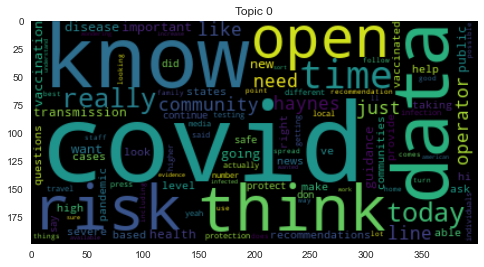

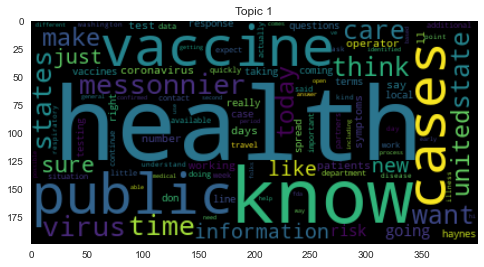

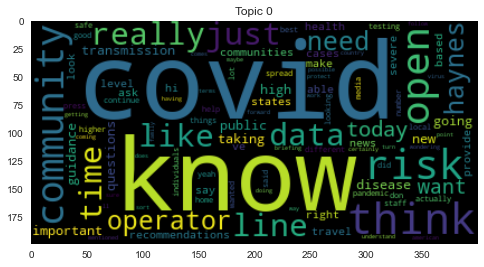

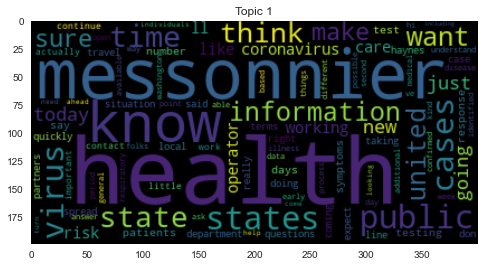

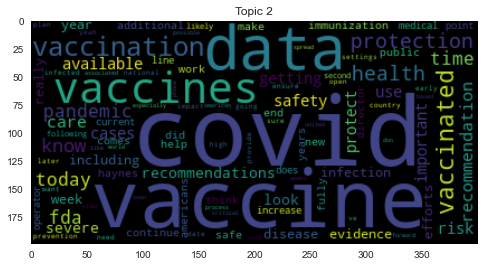

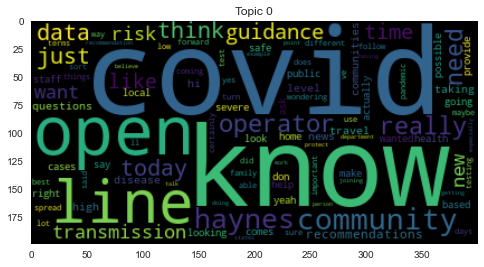

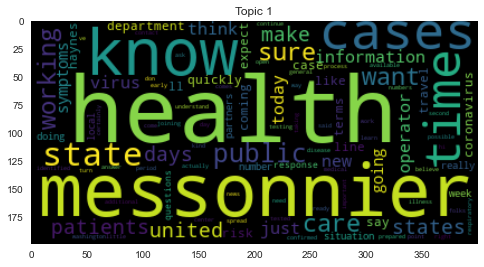

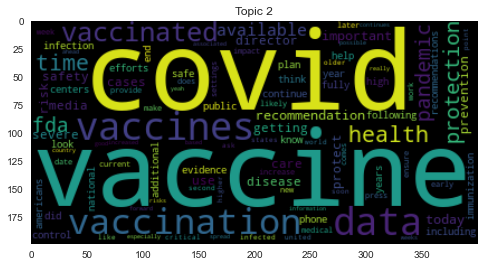

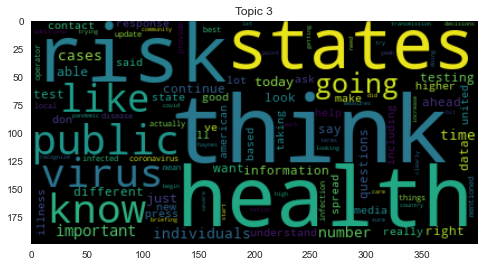

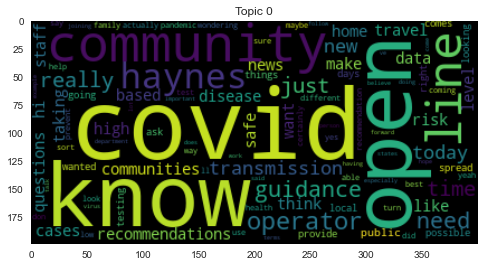

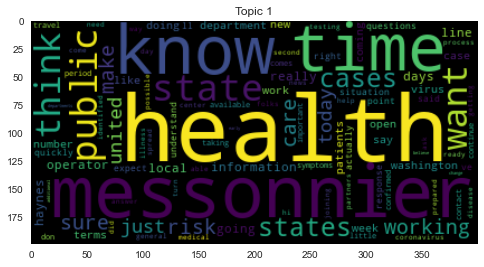

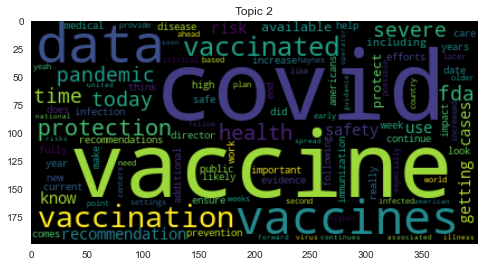

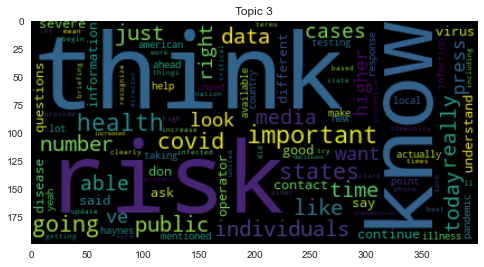

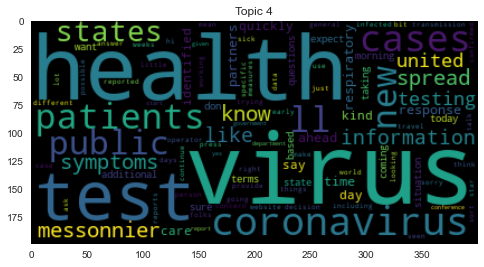

In [24]:
%%time
for topic_idx in [2,3,4,5]:

   # num_topics = 3
        
    lda = LatentDirichletAllocation(n_components = topic_idx, 
                                    random_state = 0)

    lda.fit(X_transformed)

    topic_word_dist = np.array([row / row.sum() for row in lda.components_])

    print('-' * 50)
    print('Number of topics:', topic_idx)

    # list top 20 words in each topic
    for topic_idx in range(topic_idx):
        # print('\n', 'Topic ', topic_idx, ':', sep = '')
        # sort_idx = np.argsort(-topic_word_dist[topic_idx])
        # for rank in range(20):
        #     word_idx = sort_idx[rank]
        #     print('{:<80} {:<10}'.format(array_of_words[word_idx], topic_word_dist[topic_idx, word_idx]))


#for topic_idx in range(num_topics):
        wc = WordCloud(max_words = 100)
        wc.generate_from_frequencies(dict(zip(array_of_words, topic_word_dist[topic_idx])))
        plt.figure()
        plt.imshow(wc, interpolation = 'bilinear')
        plt.title('Topic %d' % topic_idx)
        plt.grid(visible = None)
       # print("\n"*3)

## Sentiment Analysis

In the analysis below, we make use of a sentiment analysis package method called "VADER" or Valence Aware Dictionary and Sentiment Reasoner, available in  the nltk package. The dictionary of positive and negative word associations is already built into the package so that part of the analysis is a bit of black box for our purposes. However, the below still yields interesting insights, despite this limitation. A tutorial for the use of this package can be found at: https://realpython.com/python-nltk-sentiment-analysis/

### Step 1: Convert List of 1 String Per Transcript to A List of Strings of **All of the Sentences** In the Dataset

Here we split each of the text files on "." - which we are using to incidate different sentences

In [25]:
sentiment_analysis_text = []
for transcript in cdc_paths:
    text = open(transcript, encoding = 'utf-8').read().lower()
    sentiment_analysis_text.append(text)


In [26]:
transcript_sentences = [text.split(".") for text in sentiment_analysis_text]

#collapse the sentences togehter so instead of a list of lists (with each sublist = 1 transcript, we get all of the sentences across all of the transcripts)
flattened_transcripts_sentences = [sentence for single_transcript in transcript_sentences for sentence in single_transcript]


print( "There are {:,} sentences acrosss the {:,} transcripts in the CDC 'neutral' corpus.".format(len(flattened_transcripts_sentences), len(transcript_sentences)))

There are 6,273 sentences acrosss the 47 transcripts in the CDC 'neutral' corpus.


### Step 2: Subset the List of Sentences That Include COVID Terms + The Top 100 Co-Occcurring Words

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal corpus. 

In [27]:

#For now, until we can do some better string cleaning, I will just be including covid-terms
covid_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in covid_terms)]

print("There are {:,} sentences across the corpus that mention one of the covid-related terms.".format(len(covid_sentences)))


There are 597 sentences across the corpus that mention one of the covid-related terms.


### Step 3: Determine the Sentiment of Each of the Sentences


In [28]:
#to run the code chunk below, you may need to run the following lines:
#import nltk
# import ssl

# try: #attempt to address SSL issues that come up
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context 

#nltk.download('vader_lexicon')


In [29]:
#import the required packages
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [30]:
#try the sentiment analysis on the covid_sentences

#store all of the compound scores
total_compound_scores = []
positive_sentences = []
negative_sentences = []
neutral_sentences = []
#first 5 sentences test
for sentence in covid_sentences:
    score = sia.polarity_scores(sentence)
    compound_score = score["compound"]
    total_compound_scores.append(compound_score)

    if compound_score == 0:
        neutral_sentences.append((sentence, score))
    elif compound_score > 0:
        positive_sentences.append((sentence, score))
    else: 
        negative_sentences.append((sentence, score))

print("The mean compound sentiment score is: {}".format(sum(total_compound_scores)/len(total_compound_scores)))
print("There are {:,} positive sentences, {:,} neutral sentences, {:,} and negative sentences.".format(len(positive_sentences), len(neutral_sentences), len(negative_sentences)))

The mean compound sentiment score is: 0.12388643216080387
There are 290 positive sentences, 157 neutral sentences, 150 and negative sentences.


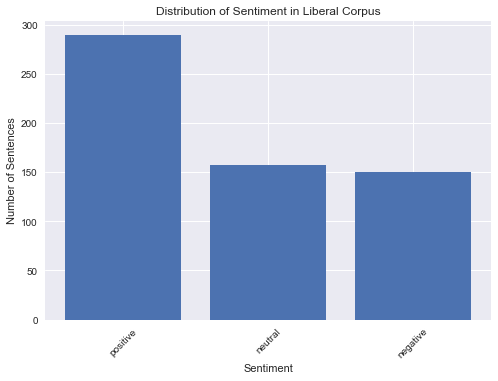

In [31]:
plt.style.use('seaborn')  

x = ["positive", "neutral", "negative"]
y = [len(positive_sentences), len(neutral_sentences), len(negative_sentences)]
plt.bar(x,y)
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Number of Sentences')
plt.title('Distribution of Sentiment in Liberal Corpus')

plt.show()

In [32]:
positive_sentences_sort = sorted(positive_sentences, key = lambda x: x[1]["pos"], reverse = True)


top_10_positive_sentences = positive_sentences_sort[:10]

for idx, combo in enumerate(top_10_positive_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Positive: {:.1%} \n Percent Neutral: {:.1%} \n Percent Negative: {:.1%} \n".format(idx+1, sentence, score["pos"], score["neu"], score["neg"]))



1.  infection of novel coronavirus 
 Percent Positive: 43.4% 
 Percent Neutral: 56.6% 
 Percent Negative: 0.0% 

2.   i’m confident that covid-19 vaccination is the way that we help 
 Percent Positive: 39.6% 
 Percent Neutral: 60.4% 
 Percent Negative: 0.0% 

3.  thank you for joining us today for this briefing to discuss safe ways to enjoy the upcoming holidays amid the covid-19 pandemic 
 Percent Positive: 38.4% 
 Percent Neutral: 61.6% 
 Percent Negative: 0.0% 

4.  the investigation into this novel coronavirus is ongoing and dynamic, and cdc is actively engaged on the many fronts that dr 
 Percent Positive: 37.6% 
 Percent Neutral: 62.4% 
 Percent Negative: 0.0% 

5. 
i and my colleagues at cdc and fda who are partners in vaccine
safety are committed to ensuring covid-19 vaccines are safe 
 Percent Positive: 36.8% 
 Percent Neutral: 63.2% 
 Percent Negative: 0.0% 

6.   please visit the 2019 novel coronavirus webpage for continued updates 
 Percent Positive: 36.5% 
 Percent Neutral

In [33]:
negative_sentences_sort = sorted(negative_sentences, key = lambda x: x[1]["neg"], reverse = True)


top_10_negative_sentences = negative_sentences_sort[:10]

for idx, combo in enumerate(top_10_negative_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Negative: {:.1%}  \n Percent Neutral: {:.1%} \n  Percent Positive: {:.1%}\n".format(idx+1, sentence, score["neg"], score["neu"], score["pos"]))


1.   as the threat of covid-19 disease and death remains a problem here in the u 
 Percent Negative: 50.0%  
 Percent Neutral: 50.0% 
  Percent Positive: 0.0%

2.   there is risk of being exposed and getting sick from this virus and there is risk of getting very sick or dying from illness with this virus 
 Percent Negative: 41.3%  
 Percent Neutral: 58.7% 
  Percent Positive: 0.0%

3.   while every death from covid-19 is tragic, i cannot imagine losing a child 
 Percent Negative: 40.4%  
 Percent Neutral: 46.8% 
  Percent Positive: 12.8%

4. 1% of all covid-19-related fatalities in the u 
 Percent Negative: 39.4%  
 Percent Neutral: 60.6% 
  Percent Positive: 0.0%

5.  adult population, they are especially vulnerable to covid-19 because they are more at risk of serious, prolonged illness 
 Percent Negative: 38.0%  
 Percent Neutral: 62.0% 
  Percent Positive: 0.0%

6. 
their risk from covid and poor outcomes from covid is still more
than their risk of a severe outcome from the vaccine 

In [34]:
#if any(sentence in transcript for sentence in positive_sentences):

#create a corpus of just the positive sentences -- so that I can then do topic modeling on this to determine the types of things that are associted with covid in this subset

positive_sentences_only = [entry[0] for entry in positive_sentences]
negative_sentences_only = [entry[0] for entry in negative_sentences]

positive_transcripts = []
negative_transcripts = []
num_positive_sentences = 0
num_negative_sentences = 0

for idx, transcript in enumerate(sentiment_analysis_text):
    for sentence in transcript.split("."):
        if sentence in positive_sentences_only:
           num_positive_sentences += 1
        if sentence in negative_sentences_only:
            num_negative_sentences += 1
        
   # print("{}.".format(idx),num_positive_sentences, num_negative_sentences)
    if 0.5*num_positive_sentences > num_negative_sentences:
      #  print("{}. {}".format(idx,transcript))
        positive_transcripts.append(transcript)
    else: 
        negative_transcripts.append(transcript)
print(len(positive_transcripts))
print(len(negative_transcripts))
            # if any(sentence in transcript for sentence in positive_sentences):




10
37


To-do :
* could do some additional work/topic LDA analysis on the negative/positive sentences to see how, even if the sentiment is negative, the nature of the negative 
* sentiment is different across conservative versus liberal corpuses

## LDA Analysis on Positive and Negative Transcripts Subset

### LDA for the Transcripts Containing Positive Sentences

In [35]:
# step 1: set up the vectorizer
#min_df_threshold = int(np.floor(0.3 * len(text_transcripts)))
vectorizer = CountVectorizer(#min_df = min_df_threshold,  #there are already much fewer transcripts + words in the cdc corpus, so I just made the rule that a word need to occur in at least a 1/3 of the documents to be counted
                                stop_words = full_stop_words)
                               # max_df = 0.8)

# step 2: apply the vectorizer to the corpus of documents and store in document matrix X
X = vectorizer.fit(positive_transcripts)

# step 3: fit transform corpus of documents
X_pos_trans = vectorizer.fit_transform(positive_transcripts)

# step 4: extract feature names and counts, create dictionary
array_of_words = vectorizer.get_feature_names_out()
array_of_counts = X_pos_trans.toarray().sum(axis = 0)
word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))


In [36]:
print("There are {:,} unique words in the vocabulary.".format(X_pos_trans.shape[1]))

There are 2,284 unique words in the vocabulary.


--------------------------------------------------
Number of topics: 5


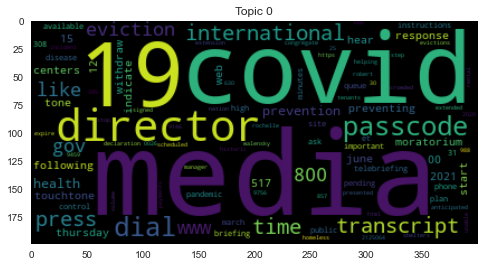

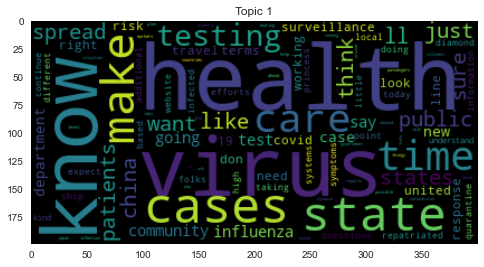

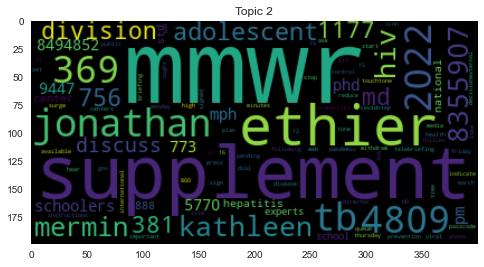

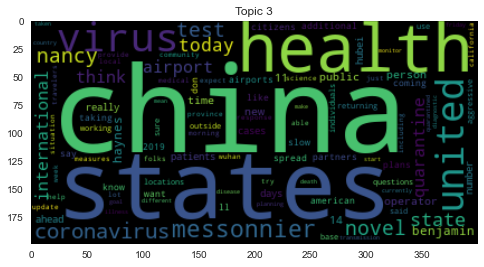

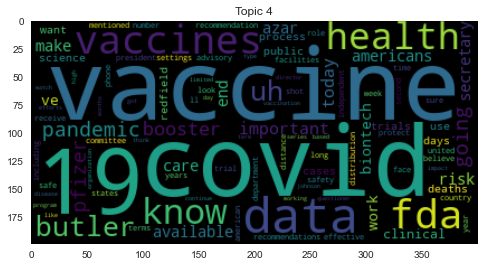

In [37]:
#for topic_idx in [2,3,4,5]:

   # num_topics = 3

topic_idx = 5       
lda = LatentDirichletAllocation(n_components = topic_idx, 
                                random_state = 0)

lda.fit(X_pos_trans)

topic_word_dist = np.array([row / row.sum() for row in lda.components_])

print('-' * 50)
print('Number of topics:', topic_idx)

# list top 20 words in each topic
for topic_idx in range(topic_idx):
    # print('\n', 'Topic ', topic_idx, ':', sep = '')
    # sort_idx = np.argsort(-topic_word_dist[topic_idx])
    # for rank in range(20):
    #     word_idx = sort_idx[rank]
    #     print('{:<80} {:<10}'.format(array_of_words[word_idx], topic_word_dist[topic_idx, word_idx]))


#for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

### LDA for the Transcripts Containing Negative Sentences

In [38]:
# step 1: set up the vectorizer
#min_df_threshold = int(np.floor(0.3 * len(text_transcripts)))
vectorizer = CountVectorizer(#min_df = min_df_threshold,  #there are already much fewer transcripts + words in the cdc corpus, so I just made the rule that a word need to occur in at least a 1/3 of the documents to be counted
                                stop_words = full_stop_words)
                               # max_df = 0.8)

# step 2: apply the vectorizer to the corpus of documents and store in document matrix X
X = vectorizer.fit(negative_transcripts)

# step 3: fit transform corpus of documents
X_neg_trans = vectorizer.fit_transform(negative_transcripts)

# step 4: extract feature names and counts, create dictionary
array_of_words = vectorizer.get_feature_names_out()
array_of_counts = X_neg_trans.toarray().sum(axis = 0)
word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))


In [39]:
print("There are {:,} unique words in the vocabulary.".format(X_neg_trans.shape[1]))

There are 4,602 unique words in the vocabulary.


--------------------------------------------------
Number of topics: 3


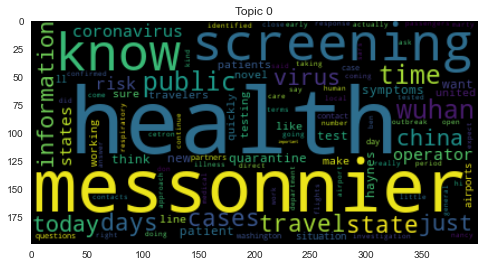

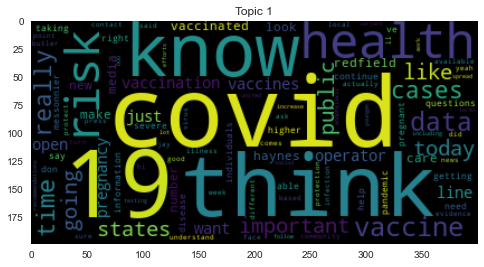

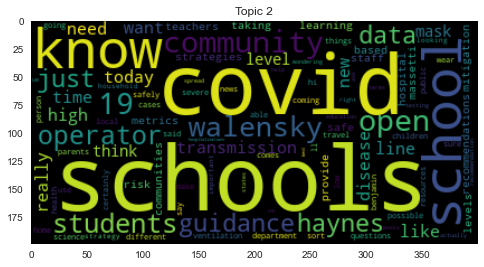

In [40]:
#for topic_idx in [2,3,4,5]:

   # num_topics = 3

topic_idx = 3      
lda = LatentDirichletAllocation(n_components = topic_idx, 
                                random_state = 0)

lda.fit(X_neg_trans)

topic_word_dist = np.array([row / row.sum() for row in lda.components_])

print('-' * 50)
print('Number of topics:', topic_idx)

# list top 20 words in each topic
for topic_idx in range(topic_idx):
    # print('\n', 'Topic ', topic_idx, ':', sep = '')
    # sort_idx = np.argsort(-topic_word_dist[topic_idx])
    # for rank in range(20):
    #     word_idx = sort_idx[rank]
    #     print('{:<80} {:<10}'.format(array_of_words[word_idx], topic_word_dist[topic_idx, word_idx]))


#for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

In [41]:
vaccine_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in vaccine_terms)]

print("There are {} sentences in the {} transcripts about vaccines.".format(len(vaccine_sentences), len(transcript_sentences)))

There are 375 sentences in the 47 transcripts about vaccines.
